# Trading Neural Network Trainer

In [2]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
import yfinance as yf
from datetime import date
import plotly
import plotly.graph_objects as go
from tqdm import tqdm
import hvplot.pandas 


---

## Prepare the data to be used on a neural network model

### Read the csv file into a Pandas DataFrame. clean variables and define target and features

In [3]:
# Read the csv file from the Training_Data folder into a Pandas DataFrame
new_df = pd.read_csv(Path("./Training_Data/XLRE.csv"), index_col="Date", parse_dates=True, infer_datetime_format=True)

# Review the DataFrame
new_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-10-08,30.010000,30.209999,30.010000,30.209999,24.521376,2000
2015-10-09,30.200001,30.200001,30.059999,30.160000,24.480793,4300
2015-10-12,30.420000,30.420000,30.270000,30.350000,24.635014,2300
2015-10-13,30.160000,30.160000,30.160000,30.160000,24.480793,500
2015-10-14,30.160000,30.160000,30.160000,30.160000,24.480793,0


### Create Function to build Basic Indicators

In [4]:
# Review the data types associated with the columns
def prepare_data(new_df):
    data_df = new_df.drop(columns=["Open", "High", "Low", "Adj Close"])

    # Make a daily percent change column
    data_df["Returns"] = data_df["Close"].pct_change()

    # Establishes our basic MAs
    data_df["10SMA"] = data_df["Close"].rolling(window=10).mean()
    data_df["20SMA"] = data_df["Close"].rolling(window=20).mean()
    data_df["50SMA"] = data_df["Close"].rolling(window=50).mean()
    data_df["100SMA"] = data_df["Close"].rolling(window=100).mean()

    # SMA % Changes
    data_df["10SMA_diff"] = (data_df["10SMA"].diff()) / data_df["10SMA"]
    data_df["20SMA_diff"] = (data_df["20SMA"].diff()) / data_df["20SMA"]
    data_df["50SMA_diff"] = (data_df["50SMA"].diff()) / data_df["50SMA"]
    data_df["100SMA_diff"] = (data_df["100SMA"].diff()) / data_df["100SMA"]

    # Builds momentum SMAs
    data_df["10SMA%"] = data_df["Returns"].rolling(window=10).mean()
    data_df["20SMA%"] = data_df["Returns"].rolling(window=20).mean()
    data_df["50SMA%"] = data_df["Returns"].rolling(window=50).mean()
    data_df["100SMA%"] = data_df["Returns"].rolling(window=100).mean()

    # Establishes our basic EMAs
    data_df["10EMA"] = data_df["Close"].ewm(span=10, adjust=False).mean()
    data_df["20EMA"] = data_df["Close"].ewm(span=20, adjust=False).mean()
    data_df["50EMA"] = data_df["Close"].ewm(span=50, adjust=False).mean()
    data_df["100EMA"] = data_df["Close"].ewm(span=100, adjust=False).mean()

    # EMA % Changes
    data_df["10EMA_diff"] = (data_df["10EMA"].diff()) / data_df["10EMA"]
    data_df["20EMA_diff"] = (data_df["20EMA"].diff()) / data_df["20EMA"]
    data_df["50EMA_diff"] = (data_df["50EMA"].diff()) / data_df["50EMA"]
    data_df["100EMA_diff"] = (data_df["100EMA"].diff()) / data_df["100EMA"]


    # Builds momentum EMAs
    data_df["10EMA%"] = data_df["Returns"].ewm(span=10, adjust=False).mean()
    data_df["20EMA%"] = data_df["Returns"].ewm(span=20, adjust=False).mean()
    data_df["50EMA%"] = data_df["Returns"].ewm(span=50, adjust=False).mean()
    data_df["100EMA%"] = data_df["Returns"].ewm(span=100, adjust=False).mean()

    # Builds a standard MACD to opperate on
    short_ema = data_df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = data_df['Close'].ewm(span=26, adjust=False).mean()
    data_df['MACD'] = short_ema - long_ema
    data_df['signal'] = data_df['MACD'].ewm(span=9, adjust=False).mean()
    data_df['MACD_hist'] = data_df['MACD'] - data_df['signal']

    # MACD Histogram diff function
    data_df["MACD_hist_diff"] = (data_df["MACD_hist"].diff()) / data_df["MACD_hist"]


    # Builds out a standard RSI Indicator

    #Creates the up and down columns to use in generating the RSI
    data_df['up_tick'] = np.where(data_df['Returns'] > 0, data_df["Returns"], 0.0)
    data_df['dn_tick'] = np.where(data_df['Returns'] < 0, abs(data_df["Returns"]), 0.0)

    # creates the rolling averages of the up and dn columns for RSI
    RS_up = data_df['up_tick'].rolling(window=14).mean()
    RS_dn = data_df['dn_tick'].rolling(window=14).mean()

    RS = RS_up / RS_dn

    # Final Calculation of RSI
    data_df['RSI'] = 100 - (100/(1 + RS))+1


    # RSI Diff
    data_df["RSI_diff"] = (data_df["RSI"].diff()) / data_df["RSI"]


    #Removes columns that are no longer neccesary (we keep uptick to define our trade signal later)

    data_df = data_df.drop(columns=["up_tick", "dn_tick"])


    # Create Base for WMA, for HullMAs on price, volatility and momentum

    # Hull Moving Averages
    # Add weights for 10 20 50 
    # RHMA = (2 * WMA(n/1)) - WMA(n)
    # HMA = WMA(sqrt(n)) of RHMA

    # WMA is sum(price * weight (number)) / (n*(n+1))/2

    # function that defines the WMA over any period
    def WMA(data, length):
           return data.rolling(length).apply(lambda x: ((np.arange(length)+1)*x).sum()/(np.arange(length)+1).sum(), raw=True)


    # function that calls the WMA function to calculate the hull moving average    
    def HMA(data, length):
           return WMA(WMA(data, length//2).multiply(2).sub(WMA(data, length)), int(np.sqrt(length)))

    # Add our HMAs to the dataframe
    data_df['10HMA'] = HMA(data_df['Close'], 10)
    data_df['20HMA'] = HMA(data_df['Close'], 20)
    data_df['50HMA'] = HMA(data_df['Close'], 50)
    data_df['100HMA'] = HMA(data_df['Close'], 100)



    # Add our HMA Diffs
    data_df["10HMA_diff"] = (data_df["10HMA"].diff()) / data_df["10HMA"]
    data_df["20HMA_diff"] = (data_df["20HMA"].diff()) / data_df["20HMA"]
    data_df["50HMA_diff"] = (data_df["50HMA"].diff()) / data_df["50HMA"]
    data_df["100HMA_diff"] = (data_df["100HMA"].diff()) / data_df["100HMA"]



    # Add Momentum HMAs to the dataframe
    data_df['10HMA%'] = HMA(data_df['Returns'], 10)
    data_df['20HMA%'] = HMA(data_df['Returns'], 20)
    data_df['50HMA%'] = HMA(data_df['Returns'], 50)
    data_df['100HMA%'] = HMA(data_df['Returns'], 100)

    # and our volatility SMAs
    data_df["10VAR"] = data_df["Returns"].rolling(window=10).var()
    data_df["20VAR"] = data_df["Returns"].rolling(window=20).var()
    data_df["50VAR"] = data_df["Returns"].rolling(window=50).var()
    data_df["100VAR"] = data_df["Returns"].rolling(window=100).var()


    # Volatility % Changes
    data_df["10VAR_diff"] = (data_df["10VAR"].diff()) / data_df["10VAR"]
    data_df["20VAR_diff"] = (data_df["20VAR"].diff()) / data_df["20VAR"]
    data_df["50VAR_diff"] = (data_df["50VAR"].diff()) / data_df["50VAR"]
    data_df["100VAR_diff"] = (data_df["100VAR"].diff()) / data_df["100VAR"]



    # Volume MAs
    data_df["10SMA_Vol"] = data_df["Volume"].rolling(window=10).mean()
    data_df["20SMA_Vol"] = data_df["Volume"].rolling(window=20).mean()
    data_df["50SMA_Vol"] = data_df["Volume"].rolling(window=50).mean()
    data_df["100SMA_Vol"] = data_df["Volume"].rolling(window=100).mean()

    # Volume SMA diffs
    data_df["10SMA_Vol_diff"] = (data_df["10SMA_Vol"].diff()) / data_df["10SMA_Vol"]
    data_df["20SMA_Vol_diff"] = (data_df["20SMA_Vol"].diff()) / data_df["20SMA_Vol"]
    data_df["50SMA_Vol_diff"] = (data_df["50SMA_Vol"].diff()) / data_df["50SMA_Vol"]
    data_df["100SMA_Vol_diff"] = (data_df["100SMA_Vol"].diff()) / data_df["100SMA_Vol"]
    
    return data_df

data_df = prepare_data(new_df)


#data_df.tail(20)
data_df.dtypes


Close              float64
Volume               int64
Returns            float64
10SMA              float64
20SMA              float64
                    ...   
100SMA_Vol         float64
10SMA_Vol_diff     float64
20SMA_Vol_diff     float64
50SMA_Vol_diff     float64
100SMA_Vol_diff    float64
Length: 61, dtype: object

### Build out a Neural Network to train

In [4]:
#First we add our target data

data_df['up_day'] = np.where(data_df['Returns'] > 0, 1.0, 0.0)

# used to be Returns shifting
data_df['Target'] = data_df['up_day'].shift(-1)
data_df = data_df.drop(columns=["up_day"])
#data_df['Target'] = data_df['Returns'].shift(-1)
# and drop our NaN variables to prepare it to train
data_df = data_df.dropna()

data_df.tail()


,Close,Volume,Returns,10SMA,20SMA,50SMA,100SMA,10SMA_diff,20SMA_diff,50SMA_diff,...,100VAR_diff,10SMA_Vol,20SMA_Vol,50SMA_Vol,100SMA_Vol,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff,Target
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-20,47.200001,5596400,0.015272,45.758,45.4590,46.4424,45.9772,0.004677,0.000583,0.000508,...,0.024484,5478860.0,6444395.0,5955942.0,5328008.0,-0.062055,-0.006486,-0.003884,0.003871,1.0
2021-10-21,47.349998,5528800,0.003178,45.982,45.5045,46.4640,46.0107,0.004871,0.001000,0.000465,...,-0.038088,5304760.0,6492260.0,5985030.0,5328173.0,-0.032820,0.007373,0.004860,0.000031,1.0
2021-10-22,47.689999,5378000,0.007181,46.289,45.5935,46.4892,46.0415,0.006632,0.001952,0.000542,...,-0.019602,5296120.0,6500580.0,6017930.0,5335963.0,-0.001631,0.001280,0.005467,0.001460,1.0
2021-10-25,47.830002,4933100,0.002936,46.604,45.7275,46.5110,46.0746,0.006759,0.002930,0.000469,...,-0.000396,5374240.0,6412180.0,6021326.0,5350821.0,0.014536,-0.013786,0.000564,0.002777,1.0
2021-10-26,48.049999,9546200,0.004600,46.881,45.8860,46.5362,46.1095,0.005909,0.003454,0.000542,...,0.002192,5762530.0,6286050.0,6114666.0,5415670.0,0.067382,-0.020065,0.015265,0.011974,0.0


In [5]:
y = data_df["Target"].copy()
y.tail()

X = data_df.drop(columns=["Target",
                          "Close", 
                          "Returns", 
                          "10SMA", 
                          "20SMA", 
                          "50SMA", 
                          "100SMA", 
                          "10EMA", 
                          "20EMA", 
                          "50EMA", 
                          "100EMA", 
                          "MACD", 
                          "signal", 
                          "MACD_hist", 
                          "RSI", 
                          "10HMA", 
                          "20HMA", 
                          "50HMA", 
                          "100HMA", 
                          "Volume", 
                          "10SMA_Vol", 
                          "20SMA_Vol", 
                          "50SMA_Vol", 
                          "100SMA_Vol"]).copy()

X.head()


,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,0.001959,0.004357,0.000339,-0.000032,0.001991,0.004450,0.000441,0.000062,0.002720,0.002924,...,0.000235,0.000186,0.067113,-0.333443,-0.042701,0.003142,0.011905,-0.038732,-0.005083,0.002223
2016-03-17,0.005176,0.005473,0.000415,0.000182,0.005199,0.005506,0.000505,0.000270,0.008314,0.005886,...,0.000239,0.000196,0.574650,0.335006,0.016966,0.049218,0.000000,-0.109375,-0.005109,-0.002228
2016-03-18,0.003172,0.004644,0.000264,0.000133,0.003266,0.004754,0.000369,0.000226,0.003688,0.003659,...,0.000243,0.000197,0.216084,0.157569,0.015395,0.006568,0.889109,0.841780,0.628910,0.212097
2016-03-21,0.002712,0.003639,0.000542,0.000066,0.002823,0.003732,0.000634,0.000162,0.002073,0.002802,...,0.000236,0.000197,0.025909,-0.013764,-0.028007,0.001367,0.012386,0.015815,0.008924,0.004449
2016-03-22,0.002676,0.003781,0.000775,0.000046,0.002798,0.003902,0.000861,0.000142,0.001372,0.002358,...,0.000232,0.000197,0.001085,-0.019033,-0.016331,0.000186,0.006477,0.007846,-0.011401,-0.002868


In [6]:
# Set Training periods
training_begin = X.index.min()
training_end = X.index.min() + DateOffset(years=14)

print(training_begin)
print(training_end)

2016-03-16 00:00:00
2030-03-16 00:00:00


In [7]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

display(X_train.head())
display(X_test.head())

,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-16,0.001959,0.004357,0.000339,-0.000032,0.001991,0.004450,0.000441,0.000062,0.002720,0.002924,...,0.000235,0.000186,0.067113,-0.333443,-0.042701,0.003142,0.011905,-0.038732,-0.005083,0.002223
2016-03-17,0.005176,0.005473,0.000415,0.000182,0.005199,0.005506,0.000505,0.000270,0.008314,0.005886,...,0.000239,0.000196,0.574650,0.335006,0.016966,0.049218,0.000000,-0.109375,-0.005109,-0.002228
2016-03-18,0.003172,0.004644,0.000264,0.000133,0.003266,0.004754,0.000369,0.000226,0.003688,0.003659,...,0.000243,0.000197,0.216084,0.157569,0.015395,0.006568,0.889109,0.841780,0.628910,0.212097
2016-03-21,0.002712,0.003639,0.000542,0.000066,0.002823,0.003732,0.000634,0.000162,0.002073,0.002802,...,0.000236,0.000197,0.025909,-0.013764,-0.028007,0.001367,0.012386,0.015815,0.008924,0.004449
2016-03-22,0.002676,0.003781,0.000775,0.000046,0.002798,0.003902,0.000861,0.000142,0.001372,0.002358,...,0.000232,0.000197,0.001085,-0.019033,-0.016331,0.000186,0.006477,0.007846,-0.011401,-0.002868


,10SMA_diff,20SMA_diff,50SMA_diff,100SMA_diff,10SMA%,20SMA%,50SMA%,100SMA%,10EMA_diff,20EMA_diff,...,50VAR,100VAR,10VAR_diff,20VAR_diff,50VAR_diff,100VAR_diff,10SMA_Vol_diff,20SMA_Vol_diff,50SMA_Vol_diff,100SMA_Vol_diff
Date,,,,,,,,,,,,,,,,,,,,,


In [8]:
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

ValueError: Found array with 0 sample(s) (shape=(0, 38)) while a minimum of 1 is required by StandardScaler.

In [9]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features


38

In [10]:
# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) // 2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1



19

In [11]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

10

In [12]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer3 =  (hidden_nodes_layer2 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer3

5

In [13]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer4 =  (hidden_nodes_layer3 + number_output_neurons) // 2

# Review the number hidden nodes in the second layer
hidden_nodes_layer4

3

In [14]:
# Create the Sequential model instance
nn = Sequential()


In [15]:
# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, activation="relu", input_dim=number_input_features))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))

# Add the fourth hidden layer
nn.add(Dense(units=hidden_nodes_layer4, activation="relu"))

# Add a dropout layer
nn.add(Dropout(0.5))


# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation="sigmoid"))

In [16]:
# Display the Sequential model summary
nn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                741       
_________________________________________________________________
dropout (Dropout)            (None, 19)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1

In [17]:
# Compile the Sequential model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
# Fit the model using 50 epochs and the training data
model = nn.fit(X_train_scaled, y_train, epochs=1500, verbose=0)

In [19]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, y_train, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


111/111 - 0s - loss: 0.6797 - accuracy: 0.5898
Loss: 0.6796635389328003, Accuracy: 0.5898382067680359


In [20]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

67/67 - 0s - loss: 0.6951 - accuracy: 0.4525
Loss: 0.6950585842132568, Accuracy: 0.45252716541290283


<AxesSubplot:>

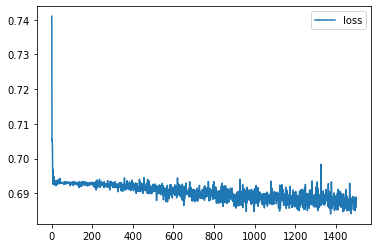

In [21]:
model_plot = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))

model_plot.plot(y="loss")

<AxesSubplot:>

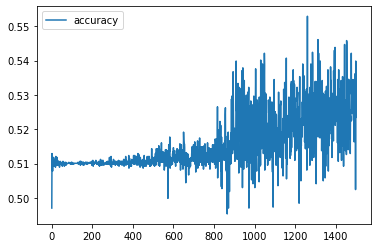

In [22]:
model_plot.plot(y="accuracy")

In [23]:
# Set the file path for the first alternative model
file_path = Path("./ETF_Neural_Nets/saved_neural_nets/XLRE.h5")

# Export your model to a HDF5 file
nn.save(file_path)


### Predictions and Performance for the bots

In [5]:
# Prepare data for back tests

def prepare_df(new_df):
    data_df = prepare_data(new_df)
    data_df = data_df.drop(columns=["Close", 
                          "Returns", 
                          "10SMA", 
                          "20SMA", 
                          "50SMA", 
                          "100SMA", 
                          "10EMA", 
                          "20EMA", 
                          "50EMA", 
                          "100EMA", 
                          "MACD", 
                          "signal", 
                          "MACD_hist", 
                          "RSI", 
                          "10HMA", 
                          "20HMA", 
                          "50HMA", 
                          "100HMA", 
                          "Volume", 
                          "10SMA_Vol", 
                          "20SMA_Vol", 
                          "50SMA_Vol", 
                          "100SMA_Vol"]).copy()
    data_df = data_df.dropna()
    return data_df
    
# scale data to be used in predictions
    
def scale_data(data_df):
    scaler = StandardScaler()

    data_scaler = scaler.fit(data_df)


    data_df = data_scaler.transform(data_df)

    
    return data_df

In [6]:
def run_backtest(tkr):
    #Load saved model
    saved_model = tf.keras.models.load_model(Path(f"./saved_neural_nets/{tkr}.h5"))

    # import historical data from yahoo finance

    end_date = date.today() + DateOffset(days=1)
    start_date = end_date - DateOffset(years=4)

    data = yf.download(tkr, start=start_date, end=end_date)

    # Run my dataframe prep function on the data
    test_df = prepare_df(data)
    scaled_df = scale_data(test_df)

    # test_df.tail(10)

    predictions = (saved_model.predict(scaled_df) > 0.5).astype("int32")
    predictions_list = []
    for prediction in predictions:
      predictions_list.append(tf.keras.backend.get_value(prediction[0]))
    test_df['prediction'] = predictions_list

    test_df['prediction'] = test_df['prediction'].shift(1)

    prediction_df = test_df['prediction']
    close_df = data.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'])
    close_df['Returns'] = close_df['Close'].pct_change()

    backtest_df = pd.concat([close_df, prediction_df], axis='columns', join='inner')

    backtest_df['Strat_Returns'] = backtest_df['Returns'] * backtest_df['prediction']

    backtest_df['Cumulative_Return'] = (1+ backtest_df['Strat_Returns']).cumprod()
    
    return backtest_df

In [7]:
# Get cumulative Returns for all Positions
possible_positions = ['GLD', 'QQQ', 'SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']

total_backtest_df = run_backtest('GLD')
total_backtest_df['GLD'] = total_backtest_df['Close']
total_backtest_df['GLD_ret'] = total_backtest_df['Returns']
total_backtest_df['GLD_pos'] = total_backtest_df['prediction']
total_backtest_df['GLD_daily'] = total_backtest_df['Strat_Returns']
total_backtest_df['GLD_tot'] = total_backtest_df['Cumulative_Return']

total_backtest_df = total_backtest_df.drop(columns=['Close', 'Returns', 'prediction', 'Strat_Returns', 'Cumulative_Return'])


for ticker in possible_positions:
    temp_df = run_backtest(ticker)
    total_backtest_df[ticker] = temp_df['Close']
    total_backtest_df[f'{ticker}_ret'] = temp_df['Returns']
    total_backtest_df[f'{ticker}_pos'] = temp_df['prediction']
    total_backtest_df[f'{ticker}_daily'] = temp_df['Strat_Returns']
    total_backtest_df[f'{ticker}_tot'] = temp_df['Cumulative_Return']

total_backtest_df.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,GLD,GLD_ret,GLD_pos,GLD_daily,GLD_tot,QQQ,QQQ_ret,QQQ_pos,QQQ_daily,QQQ_tot,...,XLV,XLV_ret,XLV_pos,XLV_daily,XLV_tot,XLY,XLY_ret,XLY_pos,XLY_daily,XLY_tot
Date,,,,,,,,,,,,,,,,,,,,,
2021-10-27,168.119995,0.002624,1.0,0.002624,1.319106,380.000000,0.002321,1.0,0.002321,2.042879,...,131.429993,-0.007926,0.0,-0.000000,1.489449,198.000000,0.002227,0.0,0.0,0.914422
2021-10-28,168.080002,-0.000238,1.0,-0.000238,1.318792,384.220001,0.011105,1.0,0.011105,2.065566,...,132.529999,0.008370,1.0,0.008370,1.501915,200.630005,0.013283,0.0,0.0,0.914422
2021-10-29,166.649994,-0.008508,1.0,-0.008508,1.307572,386.109985,0.004919,1.0,0.004919,2.075726,...,133.820007,0.009734,1.0,0.009734,1.516534,201.149994,0.002592,0.0,0.0,0.914422
2021-11-01,167.520004,0.005221,1.0,0.005221,1.314398,387.429993,0.003419,1.0,0.003419,2.082823,...,133.660004,-0.001196,0.0,-0.000000,1.516534,204.839996,0.018345,0.0,0.0,0.914422
2021-11-02,167.160004,-0.002149,1.0,-0.002149,1.311573,389.049988,0.004181,1.0,0.004181,2.091532,...,134.500000,0.006285,0.0,0.000000,1.516534,203.460007,-0.006737,0.0,-0.0,0.914422


In [8]:
# clean up the backtest data for the markowitz calculations
daily_returns_df = total_backtest_df

for ticker in possible_positions:
    daily_returns_df[ticker] = daily_returns_df[f'{ticker}_daily']
    daily_returns_df = daily_returns_df.drop(columns=[f'{ticker}_ret', f'{ticker}_daily', f'{ticker}_pos', f'{ticker}_tot'])

daily_returns_df = daily_returns_df.dropna()
daily_returns_df.head()

,GLD,QQQ,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,,,
2018-04-16,0.001412,0.007622,0.008222,0.013423,0.010223,0.004370,0.010001,0.0,0.010839,0.000000,0.013657,0.007939,0.000000
2018-04-17,0.000940,0.021525,0.010698,0.011377,0.000000,0.000000,0.008430,0.0,0.002257,0.013364,0.010105,0.007756,0.018631
2018-04-18,0.000783,0.002047,0.000740,0.007220,0.015741,-0.004714,0.010350,-0.0,-0.000000,-0.000000,-0.003727,0.000842,0.000000
2018-04-19,-0.001955,-0.009192,-0.005548,-0.011169,0.001224,0.000000,-0.002758,-0.0,-0.028933,-0.000000,-0.000591,-0.008410,-0.000000
2018-04-20,-0.007602,-0.015827,-0.008479,-0.005394,-0.004752,0.000000,-0.004346,-0.0,-0.016748,-0.000000,-0.009062,-0.005331,-0.010188


In [9]:
# Calculate annual compound return and annualized covariance matrix

means = (1+daily_returns_df.mean())**252 - 1

covars = daily_returns_df.cov()*252

# View the covariance matrix
covars

,GLD,QQQ,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
GLD,0.020942,0.001542,0.002491,0.003953,0.000040,-0.000043,0.001089,0.000802,0.002561,0.001420,0.005802,0.001285,0.001069
QQQ,0.001542,0.039530,0.028153,0.022347,0.022945,0.021805,0.025512,0.006462,0.015837,0.007596,0.011750,0.021749,0.013023
SPY,0.002491,0.028153,0.041725,0.038964,0.043472,0.041459,0.043119,0.006540,0.026545,0.015526,0.030869,0.031877,0.020524
XLB,0.003953,0.022347,0.038964,0.053305,0.051712,0.043916,0.047540,0.005263,0.026105,0.015924,0.032760,0.030231,0.019357
XLE,0.000040,0.022945,0.043472,0.051712,0.117777,0.056198,0.057513,0.004281,0.026585,0.018130,0.030386,0.032829,0.024266
XLF,-0.000043,0.021805,0.041459,0.043916,0.056198,0.063256,0.051268,0.004322,0.028436,0.016162,0.033115,0.031392,0.022601
XLI,0.001089,0.025512,0.043119,0.047540,0.057513,0.051268,0.061180,0.005323,0.028914,0.017853,0.034643,0.033493,0.021951
XLK,0.000802,0.006462,0.006540,0.005263,0.004281,0.004322,0.005323,0.010178,0.004054,0.001520,0.003625,0.004466,0.002783
XLP,0.002561,0.015837,0.026545,0.026105,0.026585,0.028436,0.028914,0.004054,0.029185,0.013179,0.029832,0.024289,0.013294
XLRE,0.001420,0.007596,0.015526,0.015924,0.018130,0.016162,0.017853,0.001520,0.013179,0.021153,0.020166,0.013674,0.007494


In [10]:
# We are allowing the portfolio to use all of the assets (if we have time we can decrease this number to calculate a portfolio for smaller accounts)
number_assets = 13


# create lists to store all of our calculated data
mean_variance_pairs = []
weights_list=[]
tickers_list=[]

# generate random portfolio allocations

for i in tqdm(range(100000)):
    next_i = False
    while True:
        # this chooses positions randomly, replace is false since we will only have a max of one position in each ticker 
        assets = daily_returns_df.columns # we can use this code if we change the number of assets to not include every ETF --> np.random.choice(daily_returns_df.columns, number_assets, replace=False)
        # chooses portfolio weights randomly and makes sure they sum to 100% (we could change this later if we wanted leveraged portfolios)
        weights = np.random.rand(number_assets)
        weights = weights/sum(weights)

        # now we loop over the asset pairs to compute variance and annual return
        portfolio_Exp_Variance = 0
        portfolio_Exp_Return = 0
        for i in range(len(assets)):
            portfolio_Exp_Return += weights[i] * means.loc[assets[i]]
            for j in range(len(assets)):
                portfolio_Exp_Variance += weights[i] * weights[j] * covars.loc[assets[i], assets[j]]

        # this skips over portfolios that dont improve upon the sharpe ratio ()
        for Ret,Var in mean_variance_pairs:
            if (Ret > portfolio_Exp_Return) & (Var < portfolio_Exp_Variance):
                next_i = True
                break
        if next_i:
            break

        # puts the mean/variance pairs in a list for plotting
        mean_variance_pairs.append([portfolio_Exp_Return, portfolio_Exp_Variance])
        weights_list.append(weights)
        tickers_list.append(assets)
        break

100%|██████████| 100000/100000 [04:19<00:00, 385.22it/s]


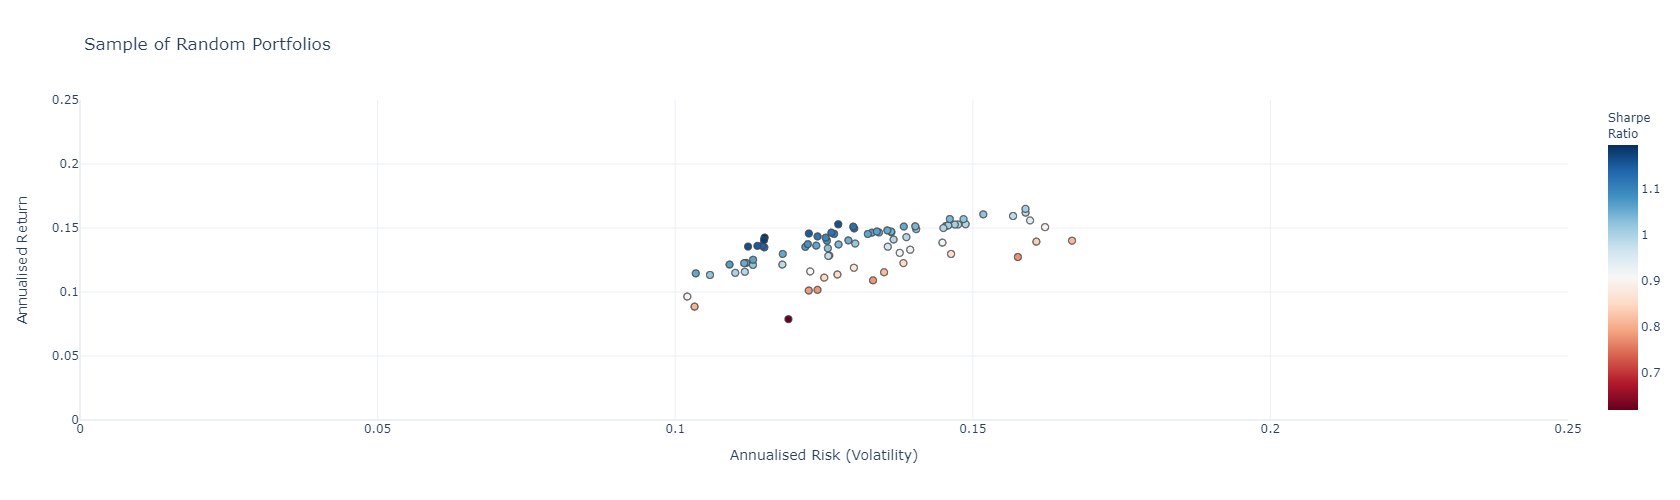

In [11]:
# Plot the risk vs. return of generated portfolios in an interactive plot

mean_variance_pairs = np.array(mean_variance_pairs)

# sets the risk free rate, ours is set to 0.5% since that is the current rate of the 2 year treasury bond
rfr= 0.50/100

fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, y=mean_variance_pairs[:,0], 
                      marker=dict(color=(mean_variance_pairs[:,0]-rfr)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers',
                      text=[str(np.array(tickers_list[i])) + "<br>" + str(np.array(weights_list[i]).round(2)) for i in range(len(tickers_list))]))
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  width=850,
                  height=500)
fig.update_xaxes(range=[0, 0.25])
fig.update_yaxes(range=[0, 0.25])
fig.update_layout(coloraxis_colorbar=dict(title="Sharpe Ratio"))

### Finally we add our portfolio weights to the Backtest to show performance

In [20]:
#mean_variance_pairs

sharpe_ratios = (mean_variance_pairs[:,0]-rfr)/(mean_variance_pairs[:,1]**0.5)
best_sharpe_ratio = np.max(sharpe_ratios)

best_sharpe_location = np.where(sharpe_ratios == best_sharpe_ratio)

1.1956871540361231

64

In [21]:
# plugged in the 88 position by hand because I couldnt figure out how to make it not a tuple to do it automatically 
best_weights = weights_list[best_sharpe_location[0][0]]
best_weights

array([0.19504067, 0.19962814, 0.08684725, 0.09289662, 0.00450948,
       0.00512032, 0.02897907, 0.13601379, 0.0073925 , 0.11930867,
       0.01905538, 0.07084311, 0.03436501])

In [22]:
# Apply porfolio weights to daily performance
weight_count = 0
for ticker in possible_positions:
    daily_returns_df[f'{ticker}_weight'] = daily_returns_df[ticker] * best_weights[weight_count]
    daily_returns_df = daily_returns_df.drop(columns=[ticker])
    weight_count += 1
    
    
daily_returns_df['Port_Performance'] = daily_returns_df.sum(axis=1)

daily_returns_df.head()

,GLD_weight,QQQ_weight,SPY_weight,XLB_weight,XLE_weight,XLF_weight,XLI_weight,XLK_weight,XLP_weight,XLRE_weight,XLU_weight,XLV_weight,XLY_weight,Port_Performance
Date,,,,,,,,,,,,,,
2018-04-16,0.000275,0.001522,0.000714,0.001247,0.000046,0.000022,0.000290,0.0,0.000080,0.000000,0.000260,0.000562,0.00000,0.005019
2018-04-17,0.000183,0.004297,0.000929,0.001057,0.000000,0.000000,0.000244,0.0,0.000017,0.001594,0.000193,0.000549,0.00064,0.009704
2018-04-18,0.000153,0.000409,0.000064,0.000671,0.000071,-0.000024,0.000300,-0.0,-0.000000,-0.000000,-0.000071,0.000060,0.00000,0.001632
2018-04-19,-0.000381,-0.001835,-0.000482,-0.001038,0.000006,0.000000,-0.000080,-0.0,-0.000214,-0.000000,-0.000011,-0.000596,-0.00000,-0.004631
2018-04-20,-0.001483,-0.003159,-0.000736,-0.000501,-0.000021,0.000000,-0.000126,-0.0,-0.000124,-0.000000,-0.000173,-0.000378,-0.00035,-0.007051


<AxesSubplot:title={'center':'Portfolio Performance (High Risk)'}, xlabel='Date'>

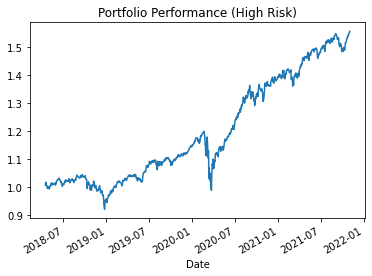

In [23]:
# Cumulative Portfolio Return

daily_returns_df['Cumulative_Return'] = (1+ daily_returns_df['Port_Performance']).cumprod()


daily_returns_df['Cumulative_Return'].plot(title="Portfolio Performance (High Risk)")

In [24]:
# Portfolios By Risk Level

# High risk is all equity
high_risk_portfolio = daily_returns_df

# Medium risk is 80% equity and 20% bond
medium_risk_portfolio = daily_returns_df * 0.8
medium_risk_portfolio['bonds'] = (0.0158/252) * 0.2
medium_risk_portfolio = medium_risk_portfolio.drop(columns=['Cumulative_Return', 'Port_Performance'])
medium_risk_portfolio['Port_Performance'] = medium_risk_portfolio.sum(axis=1)
medium_risk_portfolio['Cumulative_Return'] = (1+ medium_risk_portfolio['Port_Performance']).cumprod()

# Low risk is 60% equity and 40% bond
low_risk_portfolio = daily_returns_df * 0.6
low_risk_portfolio['bonds'] = (0.0158/252) * 0.4
low_risk_portfolio = low_risk_portfolio.drop(columns=['Cumulative_Return', 'Port_Performance'])
low_risk_portfolio['Port_Performance'] = low_risk_portfolio.sum(axis=1)
low_risk_portfolio['Cumulative_Return'] = (1+ low_risk_portfolio['Port_Performance']).cumprod()

medium_risk_portfolio.head()

,GLD_weight,QQQ_weight,SPY_weight,XLB_weight,XLE_weight,XLF_weight,XLI_weight,XLK_weight,XLP_weight,XLRE_weight,XLU_weight,XLV_weight,XLY_weight,bonds,Port_Performance,Cumulative_Return
Date,,,,,,,,,,,,,,,,
2018-04-16,0.000220,0.001217,0.000571,0.000998,0.000037,0.000018,0.000232,0.0,0.000064,0.000000,0.000208,0.000450,0.000000,0.000013,0.004028,1.004028
2018-04-17,0.000147,0.003438,0.000743,0.000846,0.000000,0.000000,0.000195,0.0,0.000013,0.001276,0.000154,0.000440,0.000512,0.000013,0.007776,1.011835
2018-04-18,0.000122,0.000327,0.000051,0.000537,0.000057,-0.000019,0.000240,-0.0,-0.000000,-0.000000,-0.000057,0.000048,0.000000,0.000013,0.001318,1.013169
2018-04-19,-0.000305,-0.001468,-0.000385,-0.000830,0.000004,0.000000,-0.000064,-0.0,-0.000171,-0.000000,-0.000009,-0.000477,-0.000000,0.000013,-0.003692,1.009427
2018-04-20,-0.001186,-0.002528,-0.000589,-0.000401,-0.000017,0.000000,-0.000101,-0.0,-0.000099,-0.000000,-0.000138,-0.000302,-0.000280,0.000013,-0.005629,1.003746


<AxesSubplot:title={'center':'Portfolio Performance (Mid Risk)'}, xlabel='Date'>

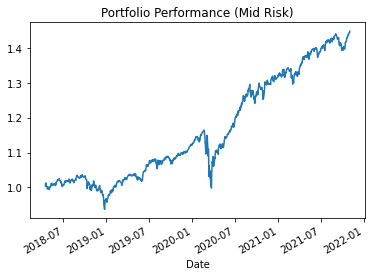

In [25]:
medium_risk_portfolio['Cumulative_Return'].hvplot(title="Portfolio Performance (Mid Risk)")

<AxesSubplot:title={'center':'Portfolio Performance (Low Risk)'}, xlabel='Date'>

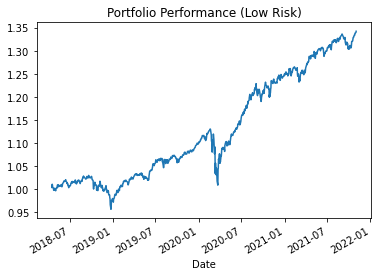

In [26]:
low_risk_portfolio['Cumulative_Return'].hvplot(title="Portfolio Performance (Low Risk)")

In [ ]:
high_risk_portfolio['Cumulative_Return'].hvplot(title="Portfolio Performance (High Risk)")

In [ ]:
# Your current profits if you invested when the project was assigned 

investment_size = 25000

proof_of_concept_df = high_risk_portfolio.loc['2021-10-25':].copy()

proof_of_concept_df['C_ret'] = (1+ proof_of_concept_df['Port_Performance']).cumprod()

perf = proof_of_concept_df['C_ret'][-1] * investment_size

print(f'If you invested ${investment_size} when the project was assigned your current profit would be {round(((perf - investment_size) / investment_size ) * 100,2)}% ${round(perf - investment_size,2)}')

